## IMPORTS

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [2]:
MODEL_NAME = "ResNet50"
DATA_DIR = "images"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

## LOADING DATA

In [3]:
# Loading the training data

## Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

## We are loading the data from the directory using the generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

Found 6039 images belonging to 2 classes.


In [4]:
# Loading the valdiation data

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

Found 1707 images belonging to 2 classes.


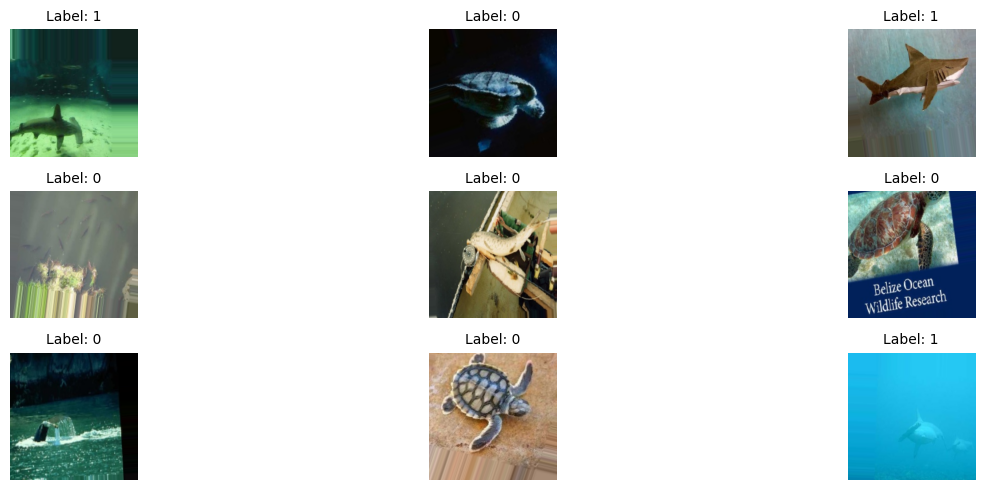

In [ ]:
# Plotting few images

## Getting one batch of images and labels from the train_generator
images, labels = next(train_generator)

## Selecting 5 images to show
num_images = 3

## Set up the plot
fig, axes = plt.subplots(num_images, num_images, figsize=(15, 5))

## Loop through the grid and plot images
for i in range(num_images * num_images):
    row = i // num_images
    col = i % num_images
    
    ax = axes[row, col]
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f"Label: {int(labels[i])}", fontsize=10)

## Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## MODEL

In [10]:
# Creating the model

def get_model():
    
    # Getting the model to start transfer learning
    base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))

    # Freeze the pre-trained layers
    base_model.trainable = False

        # Custom classification head
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid")  # Use 'softmax' for multi-class
    ])

    return model

In [11]:
# Creating callbacks

# Early Stopping Callback: Stops training if validation loss does not improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,           
    restore_best_weights=True
)

# Learning Rate Scheduler: Reduce LR when validation loss stops improving
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",  
    factor=0.5,          
    patience=3,          
    min_lr=1e-6          
)


In [12]:
# Loading and compiling the model

model = get_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [13]:
# Training the model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_scheduler],
)

/Users/tqrahman/Desktop/Project-OWL/_Github/visual-shark-tracking/shark-detection-env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 21/189 ━━━━━━━━━━━━━━━━━━━━ 8:03 3s/step - accuracy: 0.5093 - loss: 0.7991

KeyboardInterrupt: 

In [ ]:
# Plotting training history

plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()